In [1]:
"""import packages"""
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from math import pi
import functools

import tensorflow as tf
from tensorflow import keras
import app

import xlrd
from scipy.io import loadmat
import pandas as pd
import plot_boundary_on_data

In [2]:
"""global variables"""
BATCH_SIZE = 100   # number of training examples to use per training step

In [3]:
"""define flags usable from command line"""
tf.compat.v1.app.flags.DEFINE_string('f', '', 'kernel')
tf.compat.v1.app.flags.DEFINE_string('train', 'IQ_plot_data.csv',
                           'File containing the training data (labels & features).')
tf.compat.v1.app.flags.DEFINE_integer('num_epochs', 100,
                            'Number of training epochs.')
tf.compat.v1.app.flags.DEFINE_float('svmC', 10,
                            'The C parameter of the SVM cost function.')
tf.compat.v1.app.flags.DEFINE_boolean('verbose', False, 'Produce verbose output.')
tf.compat.v1.app.flags.DEFINE_boolean('plot', True, 'Plot the final decision boundary on the data.')
FLAGS = tf.compat.v1.app.flags.FLAGS

In [4]:
"""extract numpy representations of the labels and features given rows consisting of:
      label, feat_0, feat_1, ..., feat_n
   The given file should be a comma-separated-values (CSV) file saved by the savetxt command."""

def extract_data(filename):
    out = np.loadtxt(filename, delimiter=',');

    # arrays to hold the labels and feature vectors.
    labels = out[:,0]
    labels = labels.reshape(labels.size,1)
    fvecs = out[:,1:]

    # return a pair of the feature matrix and the one-hot label matrix.
    return fvecs,labels

In [5]:
def main(argv=None):
    # Be verbose?
    verbose = FLAGS.verbose

    # Plot? 
    plot = FLAGS.plot
    
    # Get the data.
    train_data_filename = FLAGS.train

    # Extract it into numpy matrices.
    train_data,train_labels = extract_data(train_data_filename)

    # Convert labels to +1,-1
    train_labels[train_labels==0] = -1

    # Get the shape of the training data.
    train_size,num_features = train_data.shape

    # Get the number of epochs for training.
    num_epochs = FLAGS.num_epochs

    # Get the C param of SVM
    svmC = FLAGS.svmC

    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step using the {feed_dict} argument to the Run() call below.
    tf.compat.v1.disable_eager_execution()
    x = tf.compat.v1.placeholder("float", shape=[None, num_features])
    y = tf.compat.v1.placeholder("float", shape=[None,1])

    # Define and initialize the network.

    # These are the weights that inform how much each feature contributes to
    # the classification.
    W = tf.Variable(tf.zeros([num_features,1]))
    b = tf.Variable(tf.zeros([1]))
    y_raw = tf.matmul(x,W) + b

    # Optimization.
    regularization_loss = 0.5*tf.reduce_sum(tf.square(W)) 
    hinge_loss = tf.reduce_sum(tf.maximum(tf.zeros([BATCH_SIZE,1]), 
        1 - y*y_raw));
    svm_loss = regularization_loss + svmC*hinge_loss;
    train_step = tf.compat.v1.train.GradientDescentOptimizer(0.01).minimize(svm_loss)

    # Evaluation.
    predicted_class = tf.sign(y_raw);
    correct_prediction = tf.equal(y,predicted_class)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    # Create a local session to run this computation.
    with tf.compat.v1.Session() as s:
        # Run all the initializers to prepare the trainable parameters.
        tf.compat.v1.initialize_all_variables().run()
        if verbose:
            print('Initialized!')
            print()
            print('Training.')

        # Iterate and train.
        for step in range(num_epochs * train_size // BATCH_SIZE):
            if verbose:
                print(step)
                
            offset = (step * BATCH_SIZE) % train_size
            batch_data = train_data[offset:(offset + BATCH_SIZE), :]
            batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
            train_step.run(feed_dict={x: batch_data, y: batch_labels})
            print('loss: ', svm_loss.eval(feed_dict={x: batch_data, y: batch_labels}))
            
            if verbose and offset >= train_size-BATCH_SIZE:
                print

        # Give very detailed output.
        if verbose:
            print()
            print('Weight matrix.')
            print(s.run(W))
            print()
            print('Bias vector.')
            print(s.run(b))
            print()
            print("Applying model to first test instance.")
            print()
            
        print("Accuracy on train:", accuracy.eval(feed_dict={x: train_data, y: train_labels}))

        if plot:
            eval_fun = lambda X: predicted_class.eval(feed_dict={x:X}); 
            plot_boundary_on_data.plot(train_data, train_labels, eval_fun)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
loss:  3.1346022e-05
loss:  3.072224e-05
loss:  3.0110867e-05
loss:  2.9511659e-05
loss:  2.8924376e-05
loss:  2.834878e-05
loss:  2.7784641e-05
loss:  2.7231727e-05
loss:  2.6689817e-05
loss:  2.615869e-05
loss:  999.99493
loss:  0.0001205426
loss:  0.000118143806
loss:  0.00011579275
loss:  0.00011348847
loss:  0.00011123005
loss:  0.00010901658
loss:  0.000106847154
loss:  0.00010472089
loss:  0.00010263695
loss:  999.99365
loss:  0.00022366385
loss:  0.00021921296
loss:  0.0002148506
loss:  0.00021057508
loss:  0.00020638463
loss:  0.00020227756
loss:  0.00019825225
loss:  0.00019430704
loss:  0.00019044032
loss:  999.988
loss:  0.00042157856
loss:  0.00041318915
loss:  0.00040496667
loss:  0.00039690782
loss:  0.00038900936
loss:  0.0003812681
loss:  0.0003736809
loss:  0.00036624464
loss:  0.00035895637
loss:  999.9886
loss:  0.00057298166
loss:  0.00056157936
loss:  0.00055040396
loss:  0.0005394509
loss: 

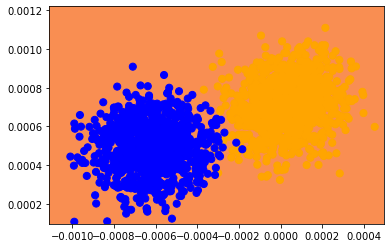

In [6]:
main()